In [3]:
import openmeteo_requests
import requests_cache
from retry_requests import retry

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
plt.style.use("styler.mplstyle") 

### Pre-Processing

In [5]:
def get_hourly_weather(lat: float,
                       long: float,
                       start: str = None,
                       end: str = None,
                       variables=None) -> pd.DataFrame:
    cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
    retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
    openmeteo = openmeteo_requests.Client(session = retry_session)

    # Make sure all required weather variables are listed here
    # The order of variables in hourly or daily is important to assign them correctly below
    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": lat,
        "longitude": long,
        "hourly": variables,
        "start_date": start,
        "end_date": end,
        "forecast_days": 0,
    }
    responses = openmeteo.weather_api(url, params=params)
    response = responses[0]
    hourly = response.Hourly()
    print(hourly)

    hourly_data = {
    "date": pd.date_range(
        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
        end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=hourly.Interval()),
        inclusive="left"
        )
    }
    for i in range(hourly.VariablesLength()):
        var = hourly.Variables(i)
        name = variables[i]
        if not name:
            name = f"var_{i}"
        hourly_data[name] = var.ValuesAsNumpy()
    

    hourly_dataframe = pd.DataFrame(data = hourly_data)

    return hourly_dataframe


In [8]:
VAR = ["temperature_2m", "relative_humidity_2m", "dew_point_2m", "apparent_temperature", "precipitation", "wind_speed_10m", "cloud_cover"]
START = '2025-08-05'
END = '2025-10-27'

In [9]:
LAT = 61.590000
LONG = -149.790000

df = get_hourly_weather(LAT,LONG, START, END, VAR)

In [10]:
df

,date,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,wind_speed_10m,cloud_cover
0,2025-08-05 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-08-05 01:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-08-05 02:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-08-05 03:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-08-05 04:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2011,2025-10-27 19:00:00+00:00,-2.006,98.0,-2.279694,-4.953838,0.0,3.396233,100.0
2012,2025-10-27 20:00:00+00:00,-1.656,98.0,-1.930489,-4.556813,0.0,3.396233,99.0
2013,2025-10-27 21:00:00+00:00,-1.106,96.0,-1.662521,-3.999627,0.0,3.600000,95.0
2014,2025-10-27 22:00:00+00:00,-0.156,91.0,-1.447919,-3.208549,0.0,4.896530,92.0


In [11]:
def plot_time_series(lat: float, lon: float, df: pd.DataFrame, variable: str):

    fig, ax = plt.subplots(figsize=(10, 6))
    fig.patch.set_facecolor("white")
    print(variable)
    # Plot the selected variable

    x = df['date'] 
    y = df[variable]

    ax.plot(
        x, 
        y, 
        color="tab:blue", 
        linewidth=1.8, 
        label=str(variable).replace("_", " ").title()
    )

    ax.set_title(
        f"Hourly {variable.replace('_', ' ')} at ({lat:.2f}, {lon:.2f})",
        fontsize=14,
        fontweight="bold",
        pad=12
    )
    ax.set_xlabel("Time (UTC)", fontsize=12)
    ax.set_facecolor("lightgrey")
    ax.set_ylabel(variable.replace("_", " ").title(), fontsize=12)
    ax.legend(frameon=True)
    plt.tight_layout()
    plt.show()

temperature_2m


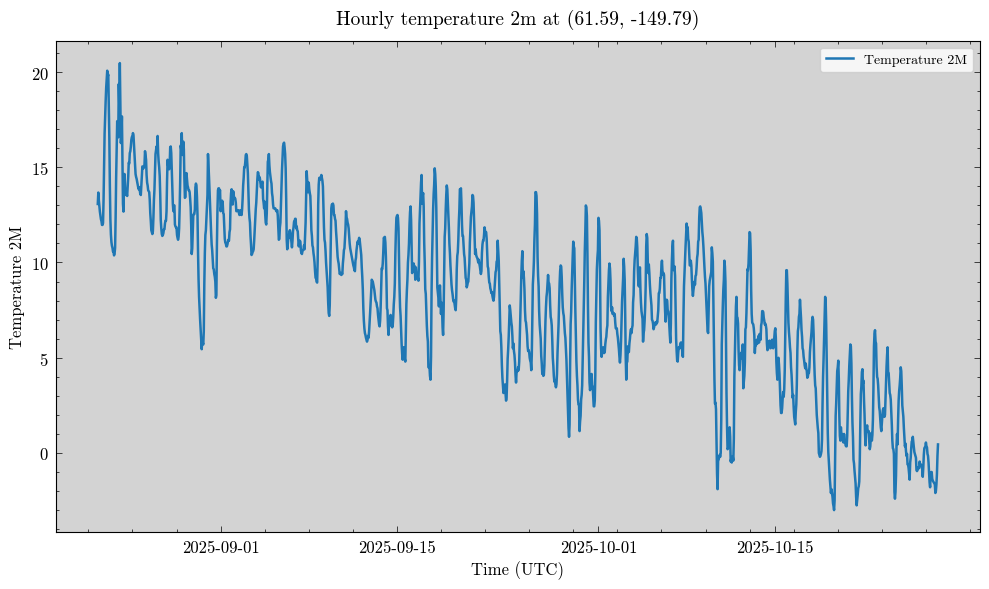

In [12]:
plot_time_series(LAT, LONG, df, 'temperature_2m')

cloud_cover


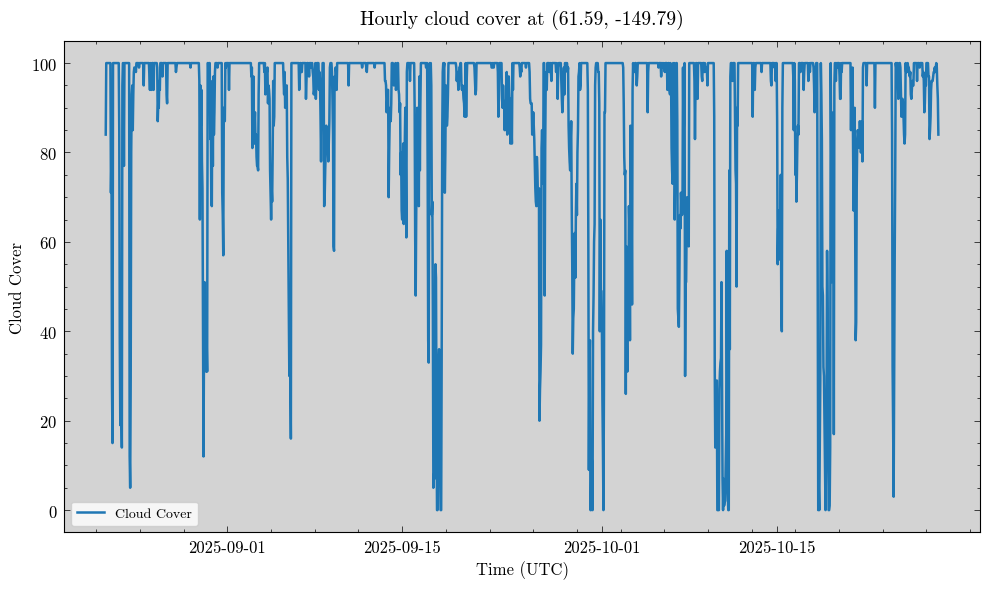

In [13]:
plot_time_series(LAT, LONG, df, 'cloud_cover')

wind_speed_10m


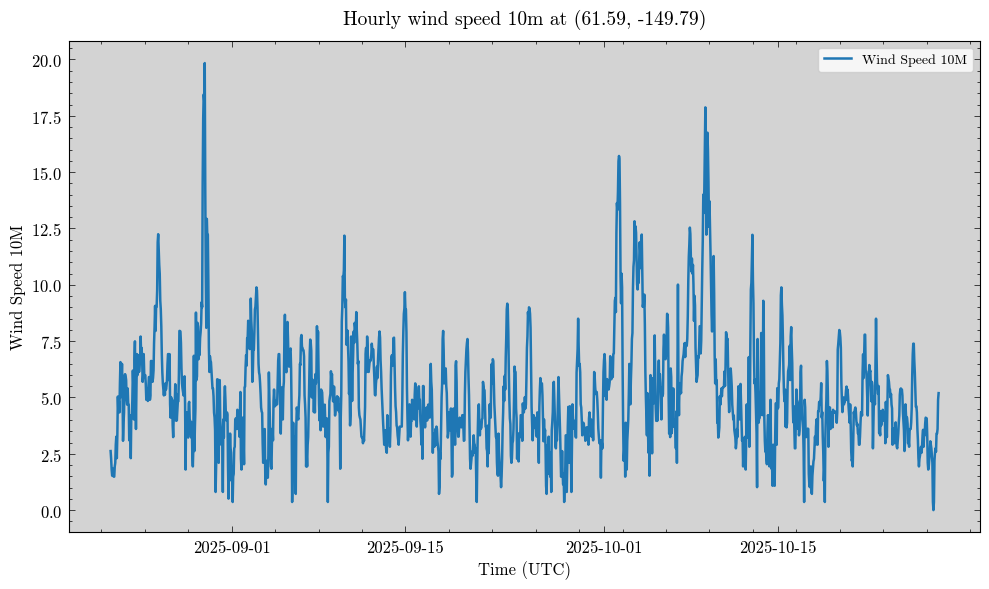

In [14]:
plot_time_series(LAT, LONG, df, 'wind_speed_10m')

<Axes: xlabel='wind_speed_10m', ylabel='Density'>

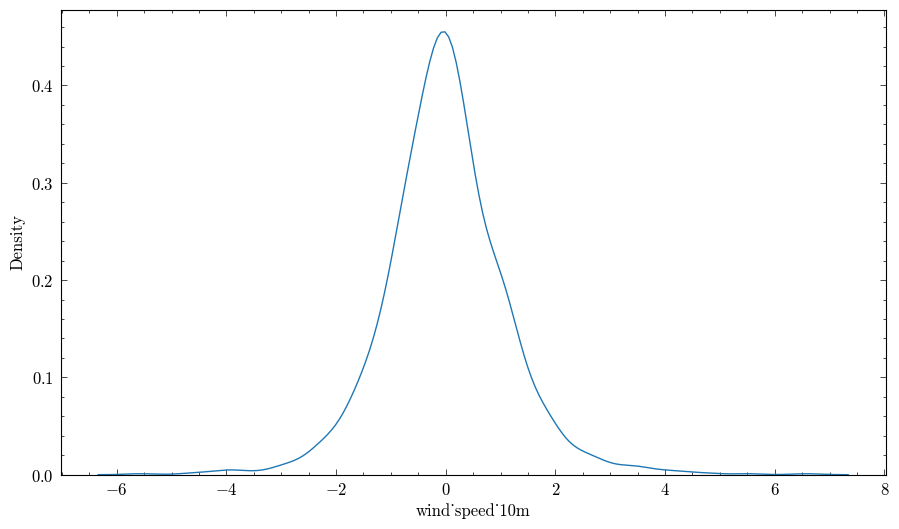

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
demeaned = (df['wind_speed_10m'] - df['wind_speed_10m'].mean()).diff()
sns.kdeplot(demeaned)

<Axes: xlabel='temperature_2m', ylabel='Density'>

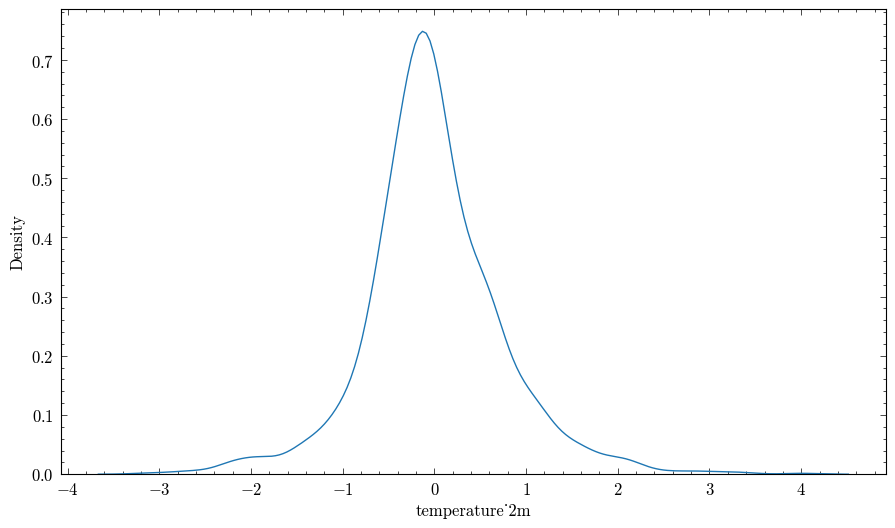

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
demeaned = (df['temperature_2m'] - df['temperature_2m'].mean()).diff()
sns.kdeplot(demeaned)